In [1]:
class FNCData:

    """

    Define class for Fake News Challenge data

    """

    def __init__(self, file_instances, file_bodies):

        # Load data
        self.instances = self.read(file_instances)
        bodies = self.read(file_bodies)
        self.heads = {}
        self.bodies = {}

        # Process instances
        for instance in self.instances:
            if instance['Headline'] not in self.heads:
                head_id = len(self.heads)
                self.heads[instance['Headline']] = head_id
            instance['Body ID'] = int(instance['Body ID'])

        # Process bodies
        for body in bodies:
            self.bodies[int(body['Body ID'])] = body['articleBody']

    def read(self, filename):

        """
        Read Fake News Challenge data from CSV file

        Args:
            filename: str, filename + extension

        Returns:
            rows: list, of dict per instance

        """

        # Initialise
        rows = []

        # Process file
        with open(filename, "r", encoding='utf-8') as table:
            r = DictReader(table)
            for line in r:
                rows.append(line)

        return rows



In [2]:
def pipeline_train(train, test, lim_unigram):
    """

    Process train set, create relevant vectorizers

    Args:
        train: FNCData object, train set
        test: FNCData object, test set
        lim_unigram: int, number of most frequent words to consider

    Returns:
        train_set: list, of numpy arrays
        train_stances: list, of ints
        bow_vectorizer: sklearn CountVectorizer
        tfreq_vectorizer: sklearn TfidfTransformer(use_idf=False)
        tfidf_vectorizer: sklearn TfidfVectorizer()

    """

    # Initialise
    heads = []
    heads_track = {}
    bodies = []
    bodies_track = {}
    body_ids = []
    id_ref = {}
    train_set = []
    train_stances = []
    cos_track = {}
    test_heads = []
    test_heads_track = {}
    test_bodies = []
    test_bodies_track = {}
    test_body_ids = []
    head_tfidf_track = {}
    body_tfidf_track = {}

    # Identify unique heads and bodies
    for instance in train.instances:
        head = instance['Headline']
        #print(head)
        body_id = instance['Body ID']
        #print(body_id)
        if head not in heads_track:
            heads.append(head)
            heads_track[head] = 1
        if body_id not in bodies_track:
            #print(train.bodies[body_id])
            bodies.append(train.bodies[body_id])
            bodies_track[body_id] = 1
            body_ids.append(body_id)

    for instance in test.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in test_heads_track:
            test_heads.append(head)
            test_heads_track[head] = 1
        if body_id not in test_bodies_track:
            test_bodies.append(test.bodies[body_id])
            test_bodies_track[body_id] = 1
            test_body_ids.append(body_id)

    # Create reference dictionary
    for i, elem in enumerate(heads + body_ids):
        id_ref[elem] = i
    print('**********id_ref******************')    
    print(id_ref)
    print('***********************************')
    
    # Create vectorizers and BOW and TF arrays for train set
    bow_vectorizer = CountVectorizer(max_features=lim_unigram, stop_words=stop_words)
    bow = bow_vectorizer.fit_transform(heads + bodies)  # Train set only
    print('***********bow*************')
    print(bow)
    print('******************************')

    tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
    tfreq = tfreq_vectorizer.transform(bow).toarray()  # Train set only
    print('**************tfreq***********')
    print(tfreq)
    print('******************************')

    tfidf_vectorizer = TfidfVectorizer(max_features=lim_unigram, stop_words=stop_words).\
        fit(heads + bodies + test_heads + test_bodies)  # Train and test sets
    print('********************tfidf**************')
    print(tfidf_vectorizer)
    print('**************************************')
    
    # Process train set
    for instance in train.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        head_tf = tfreq[id_ref[head]].reshape(1, -1)
        body_tf = tfreq[id_ref[body_id]].reshape(1, -1)
        if head not in head_tfidf_track:
            head_tfidf = tfidf_vectorizer.transform([head]).toarray()
            head_tfidf_track[head] = head_tfidf
        else:
            head_tfidf = head_tfidf_track[head]
        if body_id not in body_tfidf_track:
            body_tfidf = tfidf_vectorizer.transform([train.bodies[body_id]]).toarray()
            body_tfidf_track[body_id] = body_tfidf
        else:
            body_tfidf = body_tfidf_track[body_id]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        train_set.append(feat_vec)
        train_stances.append(label_ref[instance['Stance']])

    return train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer

In [3]:
def pipeline_test(test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer):

    """

    Process test set

    Args:
        test: FNCData object, test set
        bow_vectorizer: sklearn CountVectorizer
        tfreq_vectorizer: sklearn TfidfTransformer(use_idf=False)
        tfidf_vectorizer: sklearn TfidfVectorizer()

    Returns:
        test_set: list, of numpy arrays

    """

    # Initialise
    test_set = []
    heads_track = {}
    bodies_track = {}
    cos_track = {}

    # Process test set
    for instance in test.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in heads_track:
            head_bow = bow_vectorizer.transform([head]).toarray()
            head_tf = tfreq_vectorizer.transform(head_bow).toarray()[0].reshape(1, -1)
            head_tfidf = tfidf_vectorizer.transform([head]).toarray().reshape(1, -1)
            heads_track[head] = (head_tf, head_tfidf)
        else:
            head_tf = heads_track[head][0]
            head_tfidf = heads_track[head][1]
        if body_id not in bodies_track:
            body_bow = bow_vectorizer.transform([test.bodies[body_id]]).toarray()
            body_tf = tfreq_vectorizer.transform(body_bow).toarray()[0].reshape(1, -1)
            body_tfidf = tfidf_vectorizer.transform([test.bodies[body_id]]).toarray().reshape(1, -1)
            bodies_track[body_id] = (body_tf, body_tfidf)
        else:
            body_tf = bodies_track[body_id][0]
            body_tfidf = bodies_track[body_id][1]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        test_set.append(feat_vec)

    return test_set


In [4]:
def save_predictions(pred, file):

    """

    Save predictions to CSV file

    Args:
        pred: numpy array, of numeric predictions
        file: str, filename + extension

    """

    with open(file, 'w') as csvfile:
        fieldnames = ['Stance']
        writer = DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for instance in pred:
            writer.writerow({'Stance': label_ref_rev[instance]})


In [5]:
!pip install xgboost

In [6]:
# importing dependencies
import pandas as pd
import numpy as np
from csv import DictReader
from csv import DictWriter
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt   
import seaborn as sns    

In [7]:
# Global Variables
label_ref = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
label_ref_rev = {0: 'agree', 1: 'disagree', 2: 'discuss', 3: 'unrelated'}
stop_words = [
        "a", "about", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along",
        "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
        "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be",
        "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
        "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "co",
        "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight",
        "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
        "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill", "find", "fire", "first", "five", "for",
        "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had",
        "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself",
        "him", "himself", "his", "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed", "interest",
        "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
        "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",
        "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "nobody", "now", "nowhere",
        "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours",
        "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
        "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some",
        "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take",
        "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby",
        "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though",
        "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve",
        "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what",
        "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon",
        "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will",
        "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
        ]

In [8]:
# Fixed Variables for the code

# file names pointing to covid and economic dataset
file_train_instances = "corona_train_stances.csv"
file_train_bodies = "corona_train_bodies.csv"
file_test_instances = "corona_test_stances_unlabeled.csv"
file_test_bodies = "corona_test_bodies.csv"
file_predictions = 'xgb_corona_data_predictions_test.csv'

# file names pointing to fake news competition dataset
#file_train_instances = "train_stances.csv"
#file_train_bodies = "train_bodies.csv"
#file_test_instances = "test_stances_unlabeled.csv"
#file_test_bodies = "test_bodies.csv"
#file_predictions = 'predictions_test.csv'

In [11]:
# Initialise hyperparameters
r = random.Random()
lim_unigram = 5000
target_size = 4
hidden_size = 100
train_keep_prob = 0.6
l2_alpha = 0.00001
learn_rate = 0.01
clip_ratio = 5
batch_size_train = 500
epochs = 90

In [12]:
# Load data sets
raw_train = FNCData(file_train_instances, file_train_bodies)
raw_test = FNCData(file_test_instances, file_test_bodies)
n_train = len(raw_train.instances)

print(raw_train)
print()
print(raw_test)
print()
print(n_train)



157


In [13]:
#Process Data Sets
train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer = pipeline_train(raw_train, raw_test, lim_unigram=lim_unigram)
feature_size = len(train_set[0])
test_set = pipeline_test(raw_test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer)

**********id_ref******************
{'Coronavirus Live Updates: India Records 1,112 Covid Cases In 24 Hours': 0, 'New COVID-19 vaccination round to be launched for risk groups': 1, 'Book a coronavirus vaccination appointment in the Maisa service starting 24 October': 2, 'Influenza vaccinations and new COVID-19 vaccination round to start in October': 3, "The city's crisis management model for dealing with the coronavirus pandemic effective and efficient": 4, 'COVID-19 variant-adapted booster vaccines are as of now available in Lithuania': 5, 'Self-isolation is no longer required in the case of exposure to COVID-19': 6, 'travel restrictions on arrivals from EU to Lithuania': 7, 'From next Monday, wearing masks will no longer be mandatory but recommended, and the self-isolation period will be shorter': 8, 'List of affected countries continues unchanged': 9, '4 territories added to the orange (yellow) list': 10, 'EUR 30 million to be provided to businesses for coronavirus testing with plans

In [14]:
X = np.array(train_set)
y = np.array(train_stances)

In [15]:
X.shape

(157, 5745)

In [16]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)

In [17]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((125, 5745), (32, 5745), (125,), (32,))

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, SpatialDropout1D
from tensorflow.keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [19]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 60000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 100

In [29]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
X_train.shape, y_train.shape

((125, 5745), (125,))

In [31]:
epochs = 2
batch_size = 10
model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/2


KeyboardInterrupt: 

In [26]:
accr = model.evaluate(X_val,y_val)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1/1 [==============================] - 1s 737ms/step - loss: 0.0000e+00 - accuracy: 0.2188
Test set
  Loss: 0.000
  Accuracy: 0.219


In [138]:
model = xgb.XGBClassifier(learning_rate=0.1,
                          max_depth=5,
                          n_estimators=5000,
                          subsample=0.5,
                          colsample_bytree=0.5,
                          eval_metric='auc',
                          verbosity=1)

In [139]:
eval_set = [(X_val, y_val)]
model.fit(X_train,
          y_train,
          verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [140]:
y_pred = model.predict(X_val)

In [141]:
y_pred

array([3, 3, 3, 3, 3, 0, 3, 2, 0, 0, 2, 3, 2, 3, 1, 0, 3, 0, 1, 3, 1, 2,
       0, 2, 0, 0, 0, 1, 2, 1, 0, 0], dtype=int64)

In [142]:
y_val

array([2, 3, 3, 3, 3, 1, 2, 0, 0, 1, 0, 3, 2, 0, 0, 1, 3, 2, 2, 3, 0, 1,
       0, 2, 1, 2, 3, 0, 1, 3, 0, 2])

In [143]:
df = pd.DataFrame()
df['y_actual'] = y_val
df['y_pred'] = y_pred

In [144]:
accuracy_score(df['y_actual'],df['y_pred'])

0.375

In [145]:
target_names = ['agree','disagree','discuss','unrelated']

In [146]:
print(classification_report(df['y_actual'],df['y_pred'],target_names=target_names))

              precision    recall  f1-score   support

       agree       0.27      0.33      0.30         9
    disagree       0.00      0.00      0.00         6
     discuss       0.33      0.25      0.29         8
   unrelated       0.70      0.78      0.74         9

    accuracy                           0.38        32
   macro avg       0.33      0.34      0.33        32
weighted avg       0.36      0.38      0.36        32



In [149]:
learning_rate_list = [0.02, 0.05]
max_depth_list = [2, 3]
n_estimators_list = [1000, 2000]

params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list}

In [150]:
xgb_model = GridSearchCV(estimator=model,
                         param_grid=params_dict,
                         cv=2,
                         scoring=None,
                         return_train_score=True,
                         verbose=4)

xgb_model.fit(X, y)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=(train=0.987, test=0.544) total time=  12.9s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=1000;, score=(train=1.000, test=0.462) total time=  13.8s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=(train=1.000, test=0.544) total time=  26.7s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=2000;, score=(train=1.000, test=0.462) total time=  26.9s
[CV 1/2] END learning_rate=0.02, max_depth=3, n_estimators=1000;, score=(train=0.987, test=0.544) total time=  15.3s
[CV 2/2] END learning_rate=0.02, max_depth=3, n_estimators=1000;, score=(train=1.000, test=0.449) total time=  15.5s
[CV 1/2] END learning_rate=0.02, max_depth=3, n_estimators=2000;, score=(train=1.000, test=0.519) total time=  28.8s
[CV 2/2] END learning_rate=0.02, max_depth=3, n_estimators=2000;, score=(train=1.000, test=0.449) total time=  28.7s
[CV 

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=0.5,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.1, max_...
                                     max_cat_threshold=64, max_cat_to_onehot=4,
                                     max_delta_step=0, max_depth=5,
                                     max_leaves=0, min_child_weight=1,
                           

In [151]:
xgb_model.best_params_

{'learning_rate': 0.02, 'max_depth': 2, 'n_estimators': 1000}

In [152]:
tuned_model = xgb.XGBClassifier(learning_rate=0.02,max_depth=2,n_estimators=1000,subsample=0.5,
                          colsample_bytree=0.5,
                          eval_metric='auc',
                          verbosity=1)

In [153]:
tuned_model.fit(X_train,
          y_train,
          verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [172]:
y_pred_xgb = tuned_model.predict(X_val)

In [173]:
df = pd.DataFrame()
df['y_actual'] = y_val
df['y_pred'] = y_pred_xgb

In [174]:
accuracy_score(df['y_actual'],df['y_pred'])

0.46875

In [157]:
print(classification_report(df['y_actual'],df['y_pred'],target_names=target_names))

              precision    recall  f1-score   support

       agree       0.27      0.33      0.30         9
    disagree       0.00      0.00      0.00         6
     discuss       0.33      0.25      0.29         8
   unrelated       0.70      0.78      0.74         9

    accuracy                           0.38        32
   macro avg       0.33      0.34      0.33        32
weighted avg       0.36      0.38      0.36        32



In [158]:
pred_prob_xgb = tuned_model.predict_proba(X_val)
pred_prob_xgb

array([[0.0085061 , 0.00346093, 0.00397309, 0.98405993],
       [0.018901  , 0.04962345, 0.00927044, 0.9222051 ],
       [0.04932309, 0.01855181, 0.00989171, 0.92223334],
       [0.01184917, 0.00801731, 0.02766654, 0.95246696],
       [0.02659526, 0.00226025, 0.00471908, 0.96642536],
       [0.28303987, 0.28129616, 0.42886037, 0.00680366],
       [0.02903845, 0.01784774, 0.06502432, 0.8880895 ],
       [0.18594836, 0.16546999, 0.6276512 , 0.02093046],
       [0.44967958, 0.03366837, 0.5114042 , 0.00524779],
       [0.5412094 , 0.12855972, 0.31870353, 0.01152736],
       [0.42809203, 0.3136469 , 0.22142905, 0.03683205],
       [0.07219326, 0.05779228, 0.25135145, 0.618663  ],
       [0.32078618, 0.19953504, 0.46236944, 0.01730936],
       [0.32350117, 0.07251041, 0.16141759, 0.44257078],
       [0.3522454 , 0.5481303 , 0.0751998 , 0.02442453],
       [0.5612905 , 0.16318658, 0.26560947, 0.00991339],
       [0.09756833, 0.0749586 , 0.2244696 , 0.60300344],
       [0.32930863, 0.11545416,

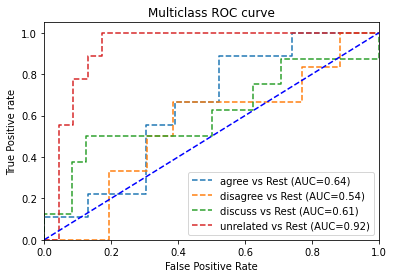

In [159]:
y_test_binarized=label_binarize(y_val,classes=np.unique(y_val))

fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()
classes = ['agree', 'disagree', 'discuss', 'unrelated']
n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob_xgb[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [160]:
rf=OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
rf.fit(X_train,y_train)
y_pred =rf.predict(X_val)
pred_prob = rf.predict_proba(X_val)

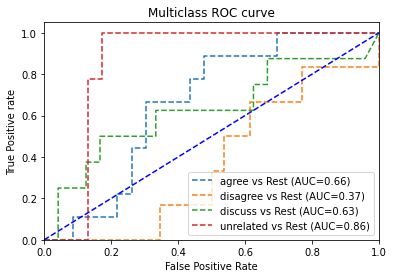

In [161]:
from sklearn.preprocessing import label_binarize

y_test_binarized=label_binarize(y_val,classes=np.unique(y_val))

fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()
classes = ['agree', 'disagree', 'discuss', 'unrelated']
n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [162]:
df = pd.DataFrame()
df['y_actual'] = y_val
df['y_pred'] = y_pred

In [163]:
accuracy_score(df['y_actual'],df['y_pred'])

0.5

In [164]:
max_depth = [2, 3]
criterion = ['gini','entropy']
n_estimators = [1000, 2000, 3000]

params_dict = {"criterion":criterion,
               "max_depth": max_depth,
               "n_estimators": n_estimators}
rf_model = GridSearchCV(estimator=RandomForestClassifier(max_features=0.2),
                         param_grid=params_dict,
                         cv=2,
                         scoring=None,
                         return_train_score=True,
                         verbose=4)

rf_model.fit(X, y)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END criterion=gini, max_depth=2, n_estimators=1000;, score=(train=0.692, test=0.544) total time=   4.7s
[CV 2/2] END criterion=gini, max_depth=2, n_estimators=1000;, score=(train=0.608, test=0.526) total time=   5.1s
[CV 1/2] END criterion=gini, max_depth=2, n_estimators=2000;, score=(train=0.705, test=0.544) total time=   9.9s
[CV 2/2] END criterion=gini, max_depth=2, n_estimators=2000;, score=(train=0.620, test=0.551) total time=   9.9s
[CV 1/2] END criterion=gini, max_depth=2, n_estimators=3000;, score=(train=0.692, test=0.544) total time=  14.1s
[CV 2/2] END criterion=gini, max_depth=2, n_estimators=3000;, score=(train=0.620, test=0.500) total time=  15.3s
[CV 1/2] END criterion=gini, max_depth=3, n_estimators=1000;, score=(train=0.885, test=0.557) total time=   5.6s
[CV 2/2] END criterion=gini, max_depth=3, n_estimators=1000;, score=(train=0.772, test=0.513) total time=   6.1s
[CV 1/2] END criterion=gini, max_de

GridSearchCV(cv=2, estimator=RandomForestClassifier(max_features=0.2),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 3],
                         'n_estimators': [1000, 2000, 3000]},
             return_train_score=True, verbose=4)

In [165]:
rf_model.best_params_

{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 3000}

In [175]:
tuned_rf_model = RandomForestClassifier(n_estimators=1000,criterion='gini',max_depth=3,max_features=0.2)
tuned_rf_model.fit(X_train,y_train)
y_pred_rf =tuned_rf_model.predict(X_val)
pred_prob = tuned_rf_model.predict_proba(X_val)

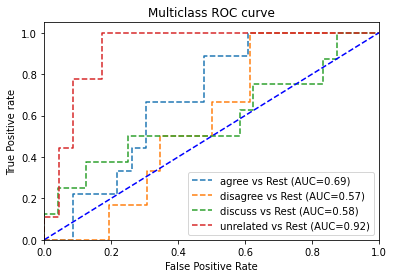

In [176]:
from sklearn.preprocessing import label_binarize

y_test_binarized=label_binarize(y_val,classes=np.unique(y_val))

fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()
classes = ['agree', 'disagree', 'discuss', 'unrelated']
n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

In [168]:
df = pd.DataFrame()
df['y_actual'] = y_val
df['y_pred'] = y_pred_rf

In [169]:
accuracy_score(df['y_actual'],df['y_pred'])

0.46875

In [170]:
print(classification_report(df['y_actual'],df['y_pred'],target_names=target_names))

              precision    recall  f1-score   support

       agree       0.36      0.89      0.52         9
    disagree       0.00      0.00      0.00         6
     discuss       0.00      0.00      0.00         8
   unrelated       0.78      0.78      0.78         9

    accuracy                           0.47        32
   macro avg       0.29      0.42      0.32        32
weighted avg       0.32      0.47      0.36        32



C:\Users\fuzel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fuzel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fuzel\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [171]:
confusion_matrix(df['y_actual'],df['y_pred'])

array([[8, 1, 0, 0],
       [6, 0, 0, 0],
       [6, 0, 0, 2],
       [2, 0, 0, 7]], dtype=int64)